# Customer Segmentation Project
This project focuses on customer segmentation using K-Means clustering. The goal is to segment customers based on their purchasing behavior and recency, providing insights for targeted marketing strategies.

# 1. Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cdist  # Import cdist for calculating distance matrices

# 2. Load the Dataset

In [3]:
# Load the dataset with error handling
try:
    df = pd.read_csv('customer_orders.csv')
except FileNotFoundError:
    print("The specified file was not found.")
    sys.exit()
except pd.errors.EmptyDataError:
    print("The file is empty.")
    sys.exit()
except pd.errors.ParserError:
    print("The file contains parsing errors.")
    sys.exit()

# 3. Initial Data Check

In [4]:
# Initial data check
print("First few rows of the dataset:")
display(df.head())
print("\nData Summary:")
display(df.info())

First few rows of the dataset:


,Customer Name,Email,Total Spent,Total Orders,Average Purchase,Average Monthly Spend,Average Monthly Orders,Last Ordered,Customer Since,Customer Lifetime
0,Melissa Zammit,NaN,"$2,995.82",64,$46.81,$65.13,1,"Jun 08, 2023","Apr 06, 2020",3 yrs 9 mos 9 dys
1,Taemyn Hollis,NaN,"$2,902.17",21,$138.20,$54.76,0,"May 19, 2023","Sep 03, 2019",4 yrs 4 mos 11 dys
2,Paul Kelsey Jr,NaN,"$2,041.59",170,$12.01,$22.44,1,"Dec 08, 2021","Jun 22, 2016",7 yrs 6 mos 23 dys
3,robert andrade,NaN,$619.83,38,$16.31,$13.77,0,"Dec 23, 2023","May 01, 2020",3 yrs 8 mos 13 dys
4,Alex Zoll,alexa.zolli92@gmail.com,$108.96,2,$54.48,$9.91,0,"Mar 02, 2023","Mar 06, 2021",10 mos 24 dys



Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5025 entries, 0 to 5024
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Customer Name           5025 non-null   object
 1   Email                   3909 non-null   object
 2   Total Spent             5025 non-null   object
 3   Total Orders            5025 non-null   int64 
 4   Average Purchase        5025 non-null   object
 5   Average Monthly Spend   5025 non-null   object
 6   Average Monthly Orders  5025 non-null   int64 
 7   Last Ordered            5025 non-null   object
 8   Customer Since          5025 non-null   object
 9   Customer Lifetime       5025 non-null   object
dtypes: int64(2), object(8)
memory usage: 392.7+ KB


None

# 4. Data Preprocessing
Clean the data, standardize column names, and prepare it for analysis.

In [5]:
# Make a copy of the dataset
df_copy = df.copy()

# Standardize column names
df_copy.columns = df_copy.columns.str.replace(' ', '_', regex=False).str.lower()

# Drop irrelevant columns
if 'email' in df_copy.columns:
    df_copy.drop('email', axis=1, inplace=True)

# Anonymize customer names if the column exists
if 'customer_name' in df_copy.columns:
    df_copy['customer_name'] = df_copy['customer_name'].apply(lambda x: 'Customer_' + str(hash(x) % 10**8))

# Convert numeric columns to floats after removing special characters
numeric_columns = ['total_spent', 'total_orders', 'average_purchase', 'average_monthly_spend', 'average_monthly_orders']

for col in numeric_columns:
    if col in df_copy.columns:
        # Remove special characters and convert to numeric, handling errors by setting them to NaN
        df_copy[col] = pd.to_numeric(df_copy[col].replace(r'[\$,]', '', regex=True), errors='coerce')

# Handle non-numeric values by imputing with the median (use .loc to avoid chained assignment)
for col in numeric_columns:
    df_copy.loc[:, col] = df_copy[col].fillna(df_copy[col].median())

# Convert date columns to datetime format with error handling
date_columns = ['customer_since', 'last_ordered']
for date_col in date_columns:
    if date_col in df_copy.columns:
        df_copy[date_col] = pd.to_datetime(df_copy[date_col], errors='coerce')

# Handle missing values for any remaining numeric columns
df_copy[numeric_columns] = df_copy[numeric_columns].fillna(df_copy[numeric_columns].median())

# 5. Feature Engineering
Create new features such as customer tenure and recency to enhance the analysis.

In [6]:
# 1. Feature Engineering - calculate customer tenure and recency
df_copy['customer_tenure'] = (df_copy['last_ordered'] - df_copy['customer_since']).dt.days
df_copy['recency'] = (pd.to_datetime('today') - df_copy['last_ordered']).dt.days

# Replace invalid or negative tenure/recency with zero or appropriate values
df_copy['customer_tenure'] = df_copy['customer_tenure'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)
df_copy['recency'] = df_copy['recency'].apply(lambda x: max(x, 0) if pd.notnull(x) else 0)

# Define a threshold for what constitutes a high-value purchase
high_value_threshold = 100  # Adjust this value based on your specific business context

# Create a binary feature for high-value purchases
df_copy['high_value_purchase'] = np.where(df_copy['average_purchase'] > high_value_threshold, 1, 0)

# Calculate the time since first purchase in days
df_copy['time_since_first_purchase'] = (pd.to_datetime('today') - df_copy['customer_since']).dt.days

# Create the 'spend_per_order' feature, handling division by zero
df_copy['spend_per_order'] = df_copy['total_spent'] / df_copy['total_orders'].replace(0, np.nan)

# Add Frequency Score (e.g., orders per year), handling division by zero
df_copy['frequency_score'] = df_copy['total_orders'] / (df_copy['customer_tenure'] / 365.25).replace(0, np.nan)

# Interaction features, handling division by zero
df_copy['spend_per_order_recency'] = df_copy['spend_per_order'] / (df_copy['recency'] + 1)

# Log-transform recency to handle skewness
df_copy['log_recency'] = np.log1p(df_copy['recency'])

# Lifetime Value (LTV) feature, ensuring that tenure isn't zero
df_copy['lifetime_value'] = np.where(df_copy['customer_tenure'] > 0, df_copy['total_spent'] / df_copy['customer_tenure'], 0)

# Handle potential infinity values if customer_tenure is zero
df_copy['lifetime_value'] = df_copy['lifetime_value'].replace([np.inf, -np.inf], 0)

# 2. Multicollinearity Check (Place this before scaling)
def check_multicollinearity(df, threshold=0.8):
    """
    Check for multicollinearity among features and drop highly correlated ones.
    """
    # Select only numeric columns for correlation matrix
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    corr_matrix = numeric_df.corr().abs()
    
    # Identify the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation above the threshold
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    if high_corr_features:
        print(f"Highly correlated features (threshold={threshold}): {high_corr_features}")
        df.drop(columns=high_corr_features, inplace=True)
    else:
        print("No multicollinearity detected above the threshold.")

# Apply multicollinearity check
check_multicollinearity(df_copy, threshold=0.8)

# 3. Scaling Step (This is where you update the scaling)
# Remove 'total_spent' and 'total_orders' after multicollinearity check and keep 'spend_per_order'
columns_to_scale = ['time_since_first_purchase', 'recency', 'frequency_score', 'spend_per_order_recency', 'spend_per_order']

# Ensure only existing columns are scaled
columns_to_scale = [col for col in columns_to_scale if col in df_copy.columns]

# Apply StandardScaler
scaler_time = StandardScaler()
df_copy[columns_to_scale] = scaler_time.fit_transform(df_copy[columns_to_scale])

# Verify the new features
print("Summary statistics after feature engineering:")
display(df_copy.describe())

Highly correlated features (threshold=0.8): ['spend_per_order', 'log_recency']
Summary statistics after feature engineering:


,total_spent,total_orders,average_purchase,average_monthly_spend,average_monthly_orders,last_ordered,customer_since,customer_tenure,recency,high_value_purchase,time_since_first_purchase,frequency_score,spend_per_order_recency,lifetime_value
count,5025.000000,5025.000000,5025.000000,5025.000000,5025.000000,5025,5025,5025.000000,5.025000e+03,5025.000000,5.025000e+03,3.762000e+03,5.025000e+03,5025.000000
mean,91.954762,3.324577,34.852736,4.664764,0.034030,2021-07-18 13:33:51.044776192,2019-04-21 08:33:31.701492736,819.208557,-6.504471e-17,0.054328,-7.140778e-17,2.266484e-17,3.959243e-17,2.427355
min,4.450000,1.000000,4.450000,0.050000,0.000000,2014-12-16 00:00:00,2012-10-25 00:00:00,0.000000,-1.176966e+00,0.000000,-1.861326e+00,-2.508250e-01,-5.800284e-01,0.000000
25%,19.800000,1.000000,14.470000,0.590000,0.000000,2020-06-23 00:00:00,2017-03-26 00:00:00,0.000000,-8.345981e-01,0.000000,-6.919697e-01,-2.470957e-01,-4.361545e-01,0.000000
50%,35.510000,1.000000,22.950000,1.490000,0.000000,2022-01-19 00:00:00,2019-10-13 00:00:00,530.000000,-2.373854e-01,0.000000,-1.880482e-01,-2.379242e-01,-2.737658e-01,0.031818
75%,88.060000,2.000000,38.450000,4.140000,0.000000,2023-04-28 00:00:00,2021-01-23 00:00:00,1352.000000,5.026950e-01,0.000000,8.144110e-01,-1.991613e-01,7.495939e-02,0.154031
max,2995.820000,220.000000,911.020000,529.280000,5.000000,2024-01-19 00:00:00,2024-01-14 00:00:00,3845.000000,3.097481e+00,1.000000,2.551217e+00,1.081224e+01,2.490114e+01,347.480000
std,192.981239,8.339908,41.090587,13.412739,0.217278,NaN,NaN,898.432922,1.000100e+00,0.226687,1.000100e+00,1.000133e+00,1.000100e+00,15.906495


# 6. Outlier Handling
Handle outliers in key features to avoid their influence on clustering.

In [7]:
# Define a function to calculate the IQR and identify outliers
def find_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    """
    Identify outliers using the IQR method or optionally by capping based on percentiles.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Optionally, calculate lower and upper bounds using percentiles for more robust capping
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Identify outliers in 'total_spent', 'total_orders', and 'recency'
outliers_spent, lower_spent, upper_spent = find_outliers(df_copy, 'total_spent')
outliers_orders, lower_orders, upper_orders = find_outliers(df_copy, 'total_orders')
outliers_recency, lower_recency, upper_recency = find_outliers(df_copy, 'recency')

print(f"Total Spent Outliers: {outliers_spent.shape[0]} outliers found")
print(f"Total Orders Outliers: {outliers_orders.shape[0]} outliers found")
print(f"Recency Outliers: {outliers_recency.shape[0]} outliers found")

# Cap (Winsorize) Outliers using more robust bounds
df_copy['total_spent'] = np.clip(df_copy['total_spent'], lower_spent, upper_spent)
df_copy['total_orders'] = np.clip(df_copy['total_orders'], lower_orders, upper_orders)
df_copy['recency'] = np.clip(df_copy['recency'], lower_recency, upper_recency)

print("Outliers have been capped.")

Total Spent Outliers: 102 outliers found
Total Orders Outliers: 48 outliers found
Recency Outliers: 102 outliers found
Outliers have been capped.


# 7. Feature Transformation
Apply transformations to reduce skewness in specific features.

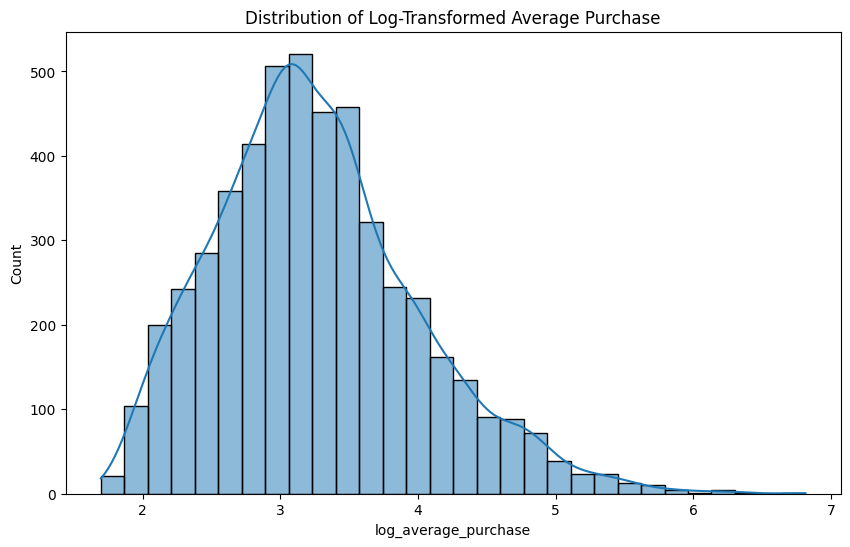

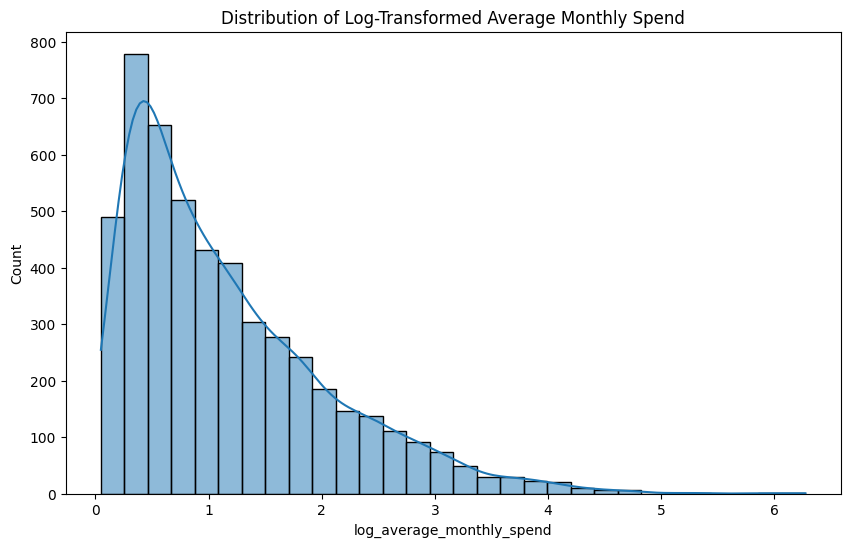

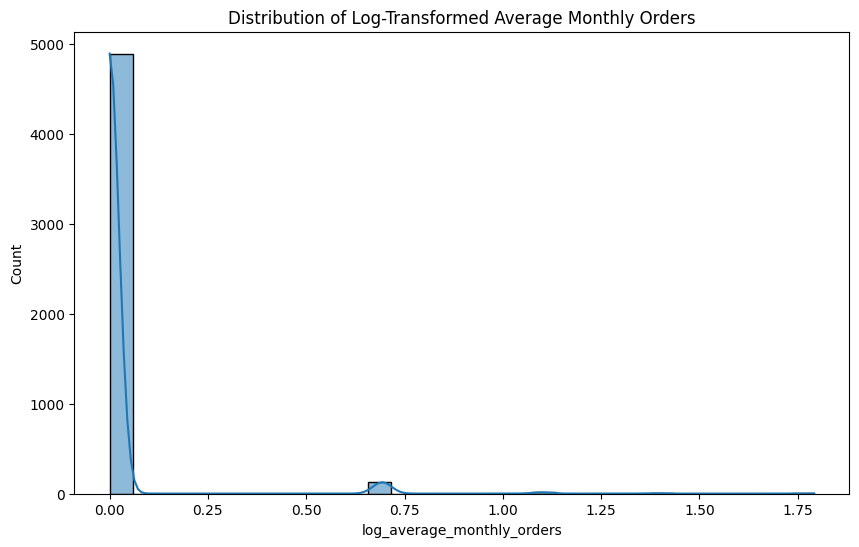

In [8]:
# Apply log transformation to reduce skewness
df_copy['log_average_purchase'] = np.log1p(df_copy['average_purchase'])
df_copy['log_average_monthly_spend'] = np.log1p(df_copy['average_monthly_spend'])
df_copy['log_average_monthly_orders'] = np.log1p(df_copy['average_monthly_orders'])

# Check the distribution after transformation
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['log_average_purchase'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Average Purchase')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_copy['log_average_monthly_spend'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Average Monthly Spend')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_copy['log_average_monthly_orders'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Average Monthly Orders')
plt.show()

# 8. Exploratory Data Analysis (EDA)
Explore the data to understand distributions and identify potential outliers.

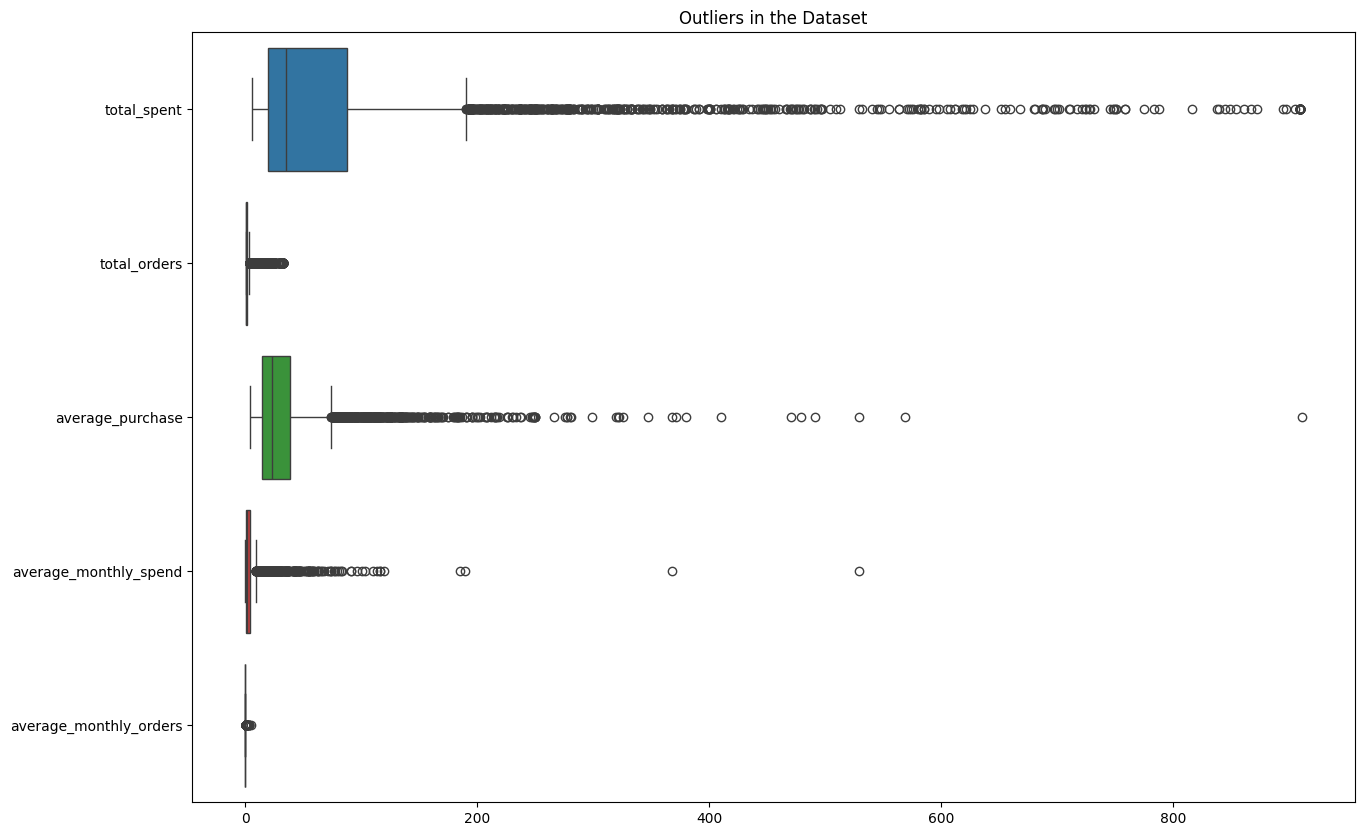

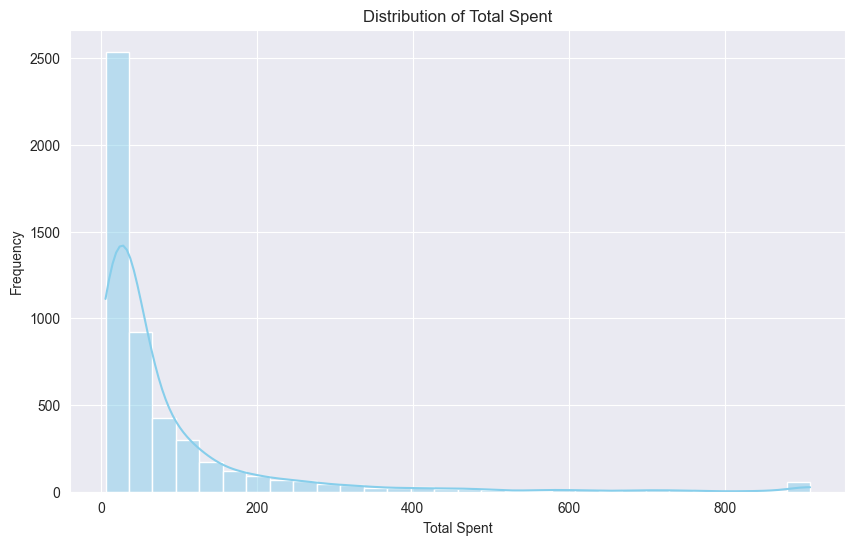

In [9]:
# Boxplot to identify outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_copy[numeric_columns], orient='h')
plt.title('Outliers in the Dataset')
plt.show()

# Histogram to understand the distribution of total spent
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['total_spent'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Frequency')
plt.show()

# 9. Clustering and Analysis
Perform clustering on the dataset to segment customers and analyze the clusters.

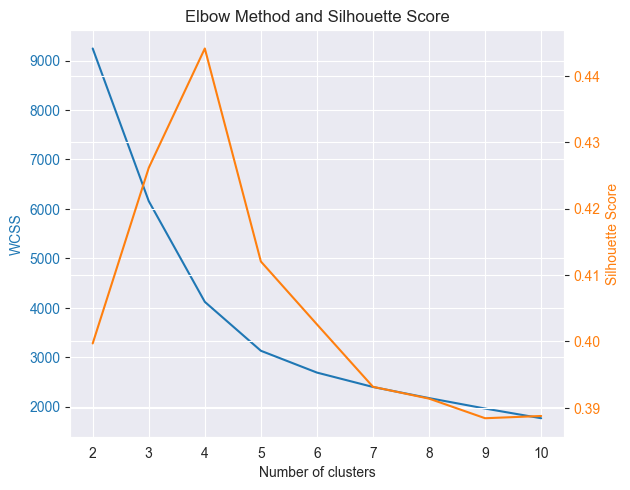

In [10]:
# Selecting features for clustering
# Since 'spend_per_order' was dropped, we need to exclude it from the clustering features
df_cluster = df_copy[['time_since_first_purchase', 'recency', 'high_value_purchase', 'frequency_score']]

# Scaling numeric features for clustering
scaler = StandardScaler()
features_to_scale = ['time_since_first_purchase', 'recency', 'high_value_purchase', 'frequency_score', 'lifetime_value']
df_copy[features_to_scale] = scaler.fit_transform(df_copy[features_to_scale])

# Handle NaN values by filling them with the median value or dropping rows
df_cluster_scaled = df_cluster.fillna(df_cluster.median())

# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
wcss = []
silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(df_cluster_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Elbow Method and Silhouette Score
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(range(2, 11), wcss, label='WCSS', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, 11), silhouette_scores, label='Silhouette Score', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Elbow Method and Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on the Elbow Method and Silhouette Score)
optimal_clusters = 4  # Update this number based on your analysis
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_copy['cluster_label'] = kmeans.fit_predict(df_cluster_scaled)

# 10. Cluster Analysis
Analyzing the characteristics of each cluster.

In [11]:
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
df_clusters = df_copy.groupby('cluster_label')[numeric_cols].mean()
print("Cluster characteristics:")
display(df_clusters)

# Descriptive statistics for each cluster
cluster_summary = df_copy.groupby('cluster_label').describe().transpose()
print("Descriptive statistics for each cluster:")
display(cluster_summary)

Cluster characteristics:


,total_spent,total_orders,average_purchase,average_monthly_spend,average_monthly_orders,customer_tenure,recency,high_value_purchase,time_since_first_purchase,frequency_score,spend_per_order_recency,lifetime_value,log_average_purchase,log_average_monthly_spend,log_average_monthly_orders,cluster_label
cluster_label,,,,,,,,,,,,,,,,
0,83.981717,2.973429,34.465224,5.771110,0.045961,446.194973,-0.397776,-0.019492,-0.734304,-0.119705,0.095799,-0.084036,3.249835,1.326663,0.030017,0.0
1,57.356929,1.902696,35.831067,0.771958,0.000000,279.213365,1.750049,0.044780,0.881927,-0.010356,-0.406107,-0.030132,3.237954,0.468120,0.000000,1.0
2,79.408969,1.164948,74.312680,4.864742,0.000000,1.123711,0.568405,0.897377,-0.402667,5.622110,0.408586,4.658265,4.000352,1.226688,0.000000,2.0
3,108.853502,3.925581,32.075287,4.835302,0.033333,2043.094574,-0.341178,-0.055006,1.032411,-0.240252,0.030990,-0.148922,3.230910,1.244221,0.020510,3.0


Descriptive statistics for each cluster:


cluster_label                             0          1          2           3
total_spent                count     2785.0      853.0       97.0      1290.0
                           mean   83.981717  57.356929  79.408969  108.853502
                           min       5.9596     5.9596       8.23      5.9596
                           25%        19.57      18.03      33.93     20.7325
                           50%        35.38      29.82      63.08       41.08
...                                     ...        ...        ...         ...
log_average_monthly_orders 25%          0.0        0.0        0.0         0.0
                           50%          0.0        0.0        0.0         0.0
                           75%          0.0        0.0        0.0         0.0
                           max     1.386294        0.0        0.0    1.791759
                           std     0.150607        0.0        0.0    0.131034

[136 rows x 4 columns]

# 11. Cluster Validation
Validating the clustering results using additional metrics.

In [12]:
# Cluster Validation - Davies-Bouldin Index
dbi = davies_bouldin_score(df_cluster_scaled, df_copy['cluster_label'])
print(f'Davies-Bouldin Index: {dbi}')

# Cluster Validation - Dunn Index
def calculate_dunn_index(X, labels):
    unique_labels = np.unique(labels)
    distances = cdist(X, X)
    
    intra_distances = []
    inter_distances = []
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            intra_distances.append(np.max(cdist(cluster_points, cluster_points)))
    
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_points_i = X[labels == unique_labels[i]]
            cluster_points_j = X[labels == unique_labels[j]]
            inter_distances.append(np.min(cdist(cluster_points_i, cluster_points_j)))
    
    return np.min(inter_distances) / np.max(intra_distances)

dunn_index = calculate_dunn_index(df_cluster_scaled, df_copy['cluster_label'])
print(f'Dunn Index: {dunn_index}')

Davies-Bouldin Index: 0.734037524176308
Dunn Index: 0.0014677439511821648


# 12. Feature Importance Analysis
Evaluate the importance of features using a RandomForest model.

In [13]:
# Create a RandomForest model to evaluate feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the scaled features with clusters as the target
rf_model.fit(df_cluster_scaled, df_copy['cluster_label'])

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i in range(df_cluster.shape[1]):
    print(f"{df_cluster.columns[indices[i]]}: {importances[indices[i]]}")

Feature ranking:
time_since_first_purchase: 0.5370551984999651
recency: 0.3184752842949453
frequency_score: 0.14400341907545394
high_value_purchase: 0.00046609812963567353


## 13. Visualization of Clusters

Visualize the clusters using PCA and other plots to understand their distribution.

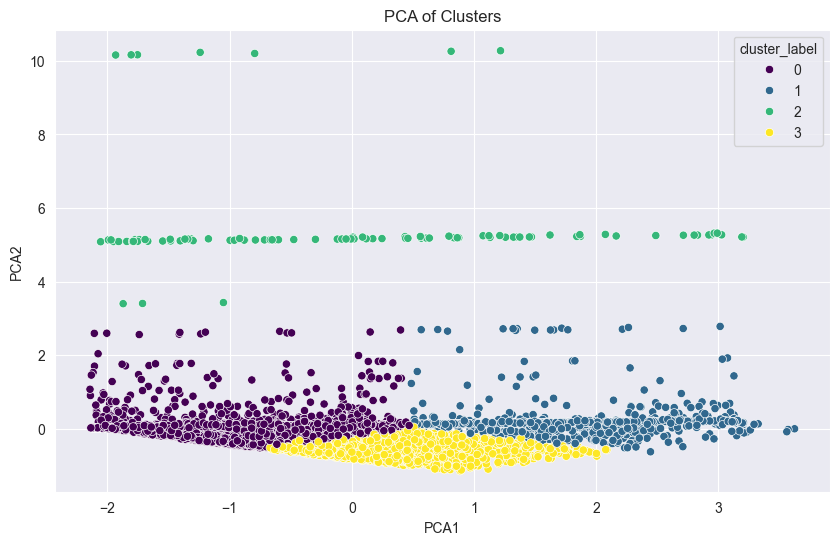

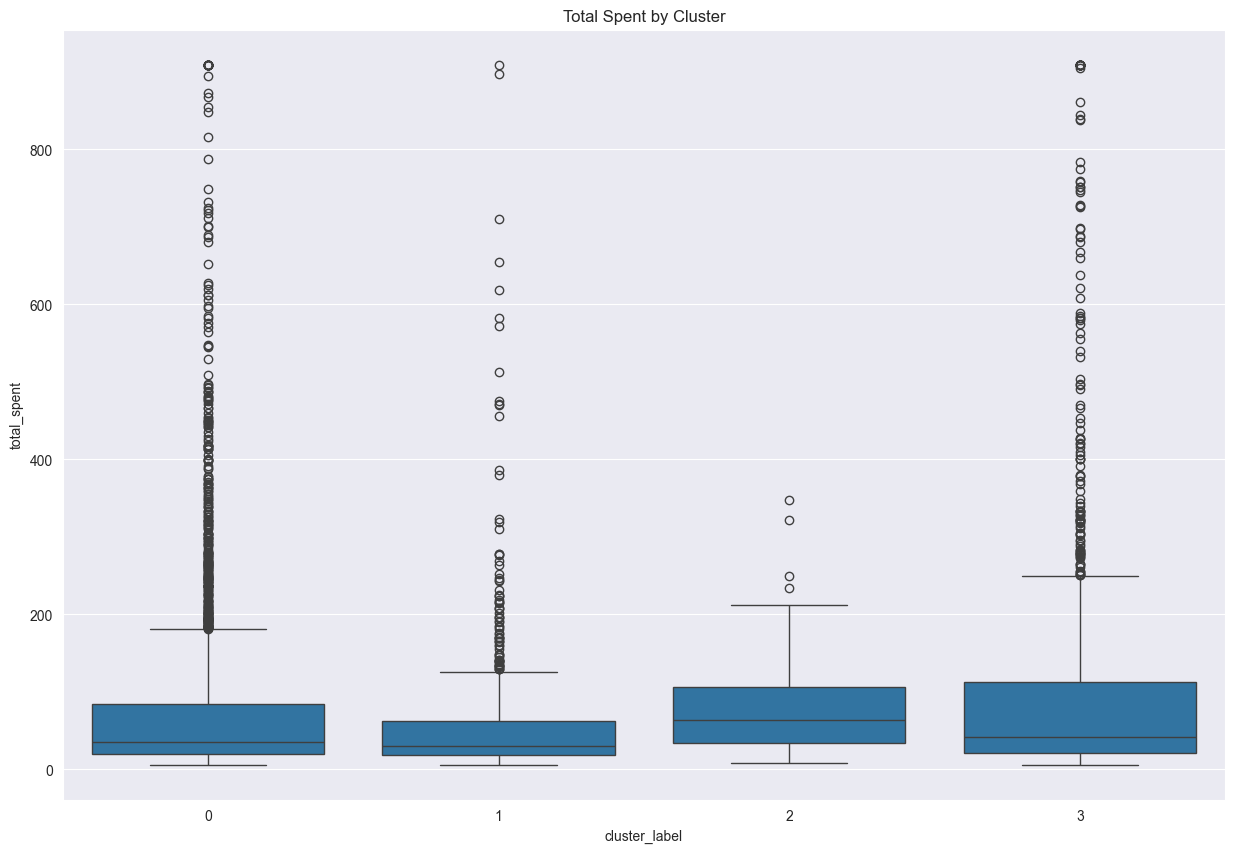

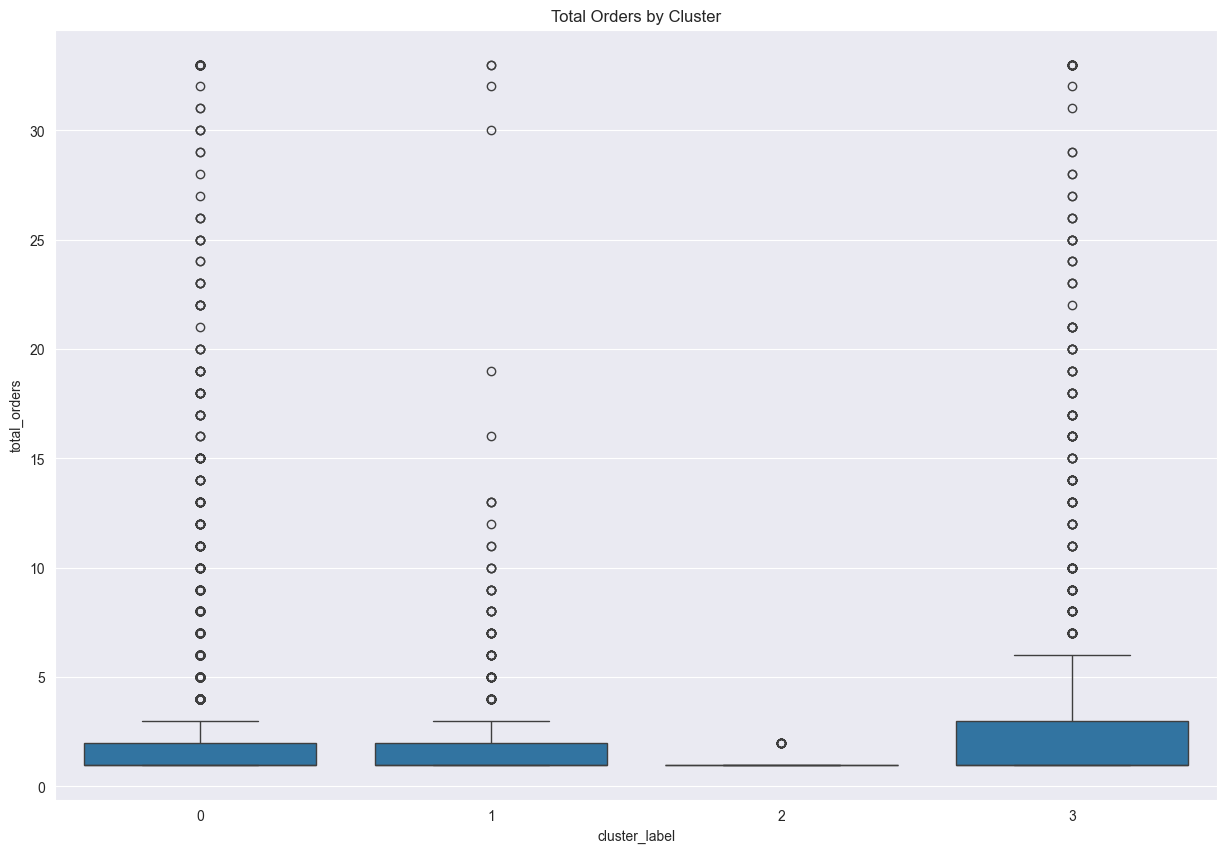

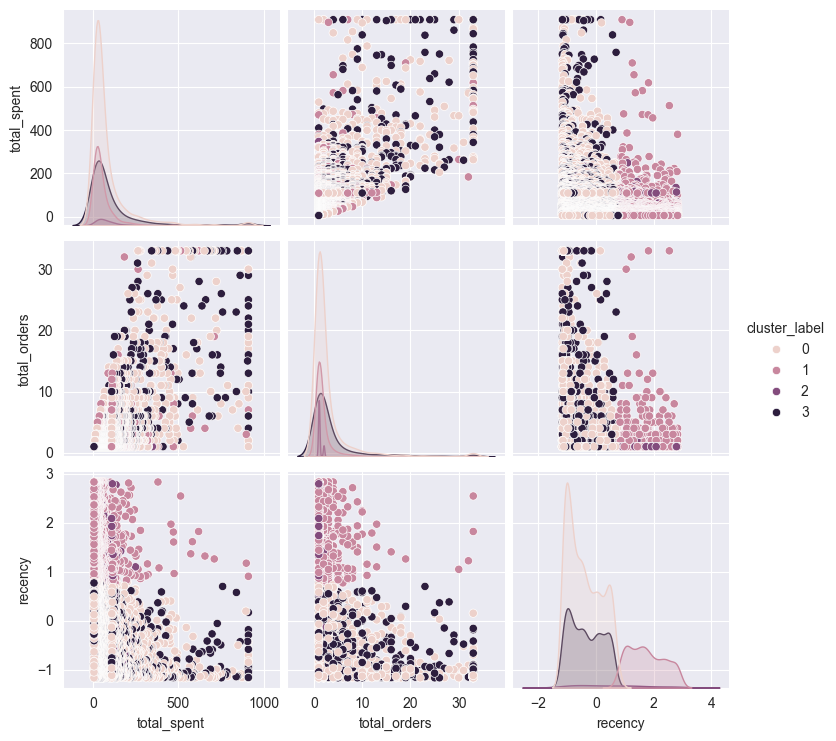

In [14]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_cluster_scaled)
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster_label'] = df_copy['cluster_label']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_label', data=pca_df, palette='viridis')
plt.title('PCA of Clusters')
plt.show()

# Box plots for numeric variables in each cluster
plt.figure(figsize=(15, 10))
sns.boxplot(x='cluster_label', y='total_spent', data=df_copy)
plt.title('Total Spent by Cluster')
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(x='cluster_label', y='total_orders', data=df_copy)
plt.title('Total Orders by Cluster')
plt.show()

# Pair plots to visualize relationships between variables in different clusters
sns.pairplot(df_copy, hue='cluster_label', vars=['total_spent', 'total_orders', 'recency'])
plt.show()

## 14. Correlation Matrix

Explore the correlations between different features in the dataset.

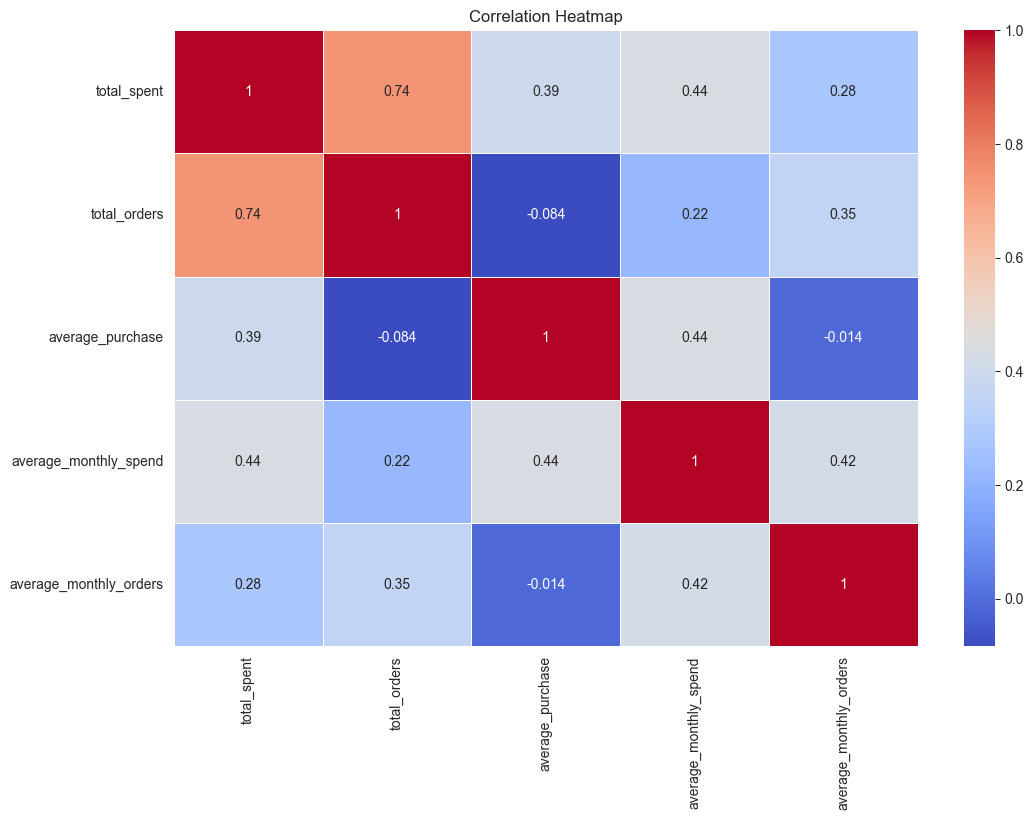

In [15]:
# Correlation matrix
correlation_matrix = df_copy[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 15. Exporting Cluster Segments

Finally, export the segmented clusters to an Excel file for further analysis or reporting.

In [19]:
with pd.ExcelWriter('customer_segments.xlsx') as writer:
    for label in df_copy['cluster_label'].unique():
        cluster_data = df_copy[df_copy['cluster_label'] == label]
        cluster_data.to_excel(writer, sheet_name=f'Cluster_{label}', index=False)

print("Cluster segments have been successfully exported to 'customer_segments.xlsx'.")

Cluster segments have been successfully exported to 'customer_segments.xlsx'.


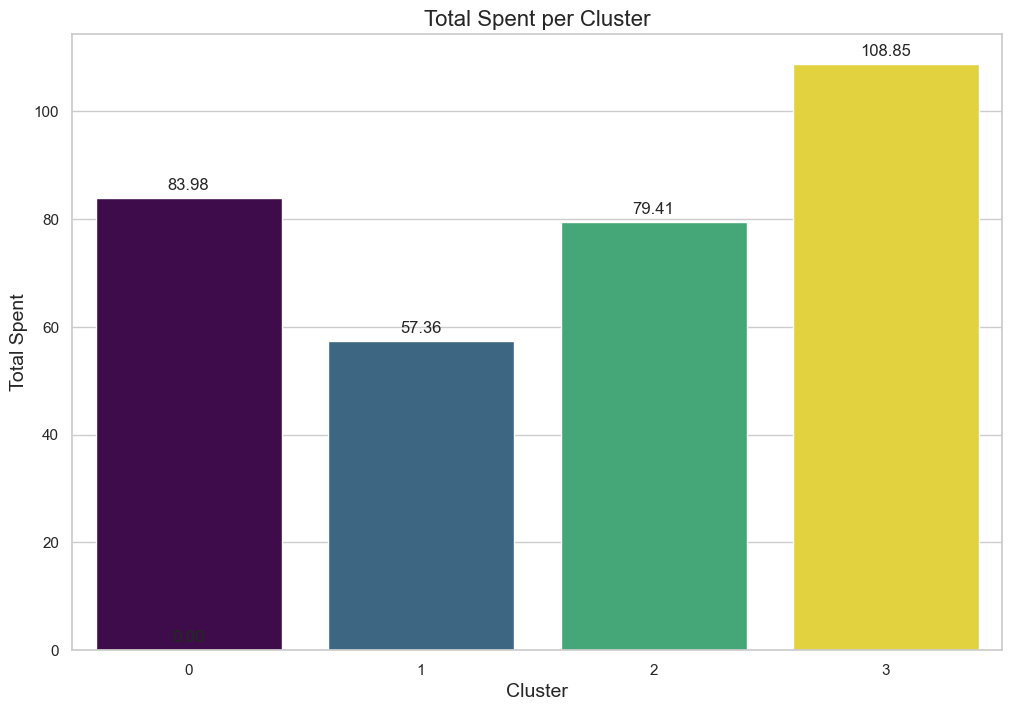

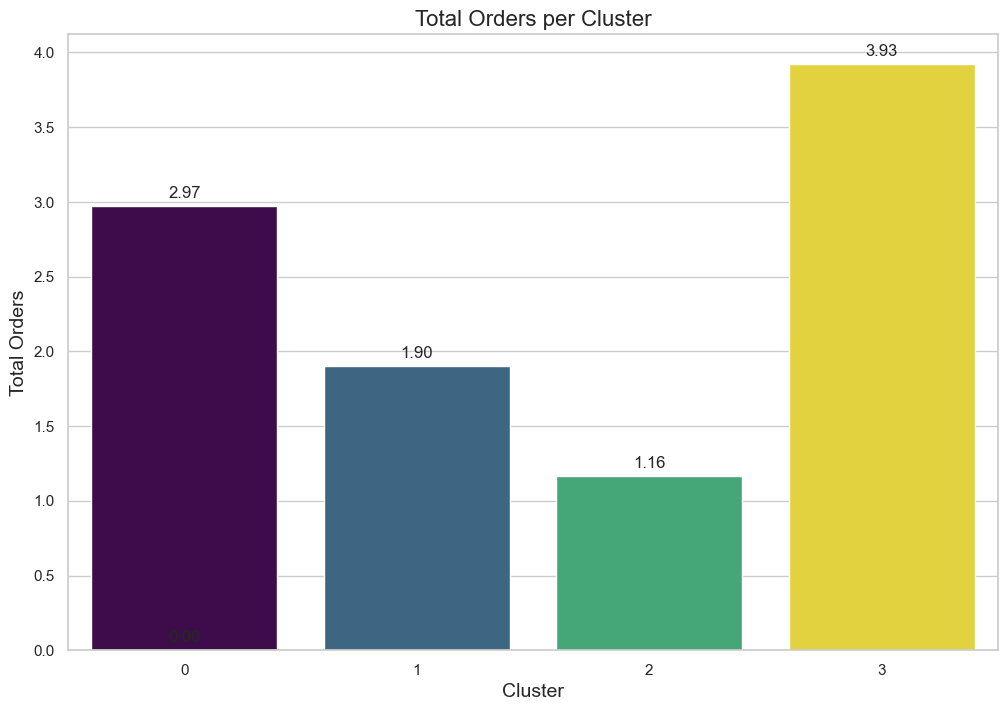

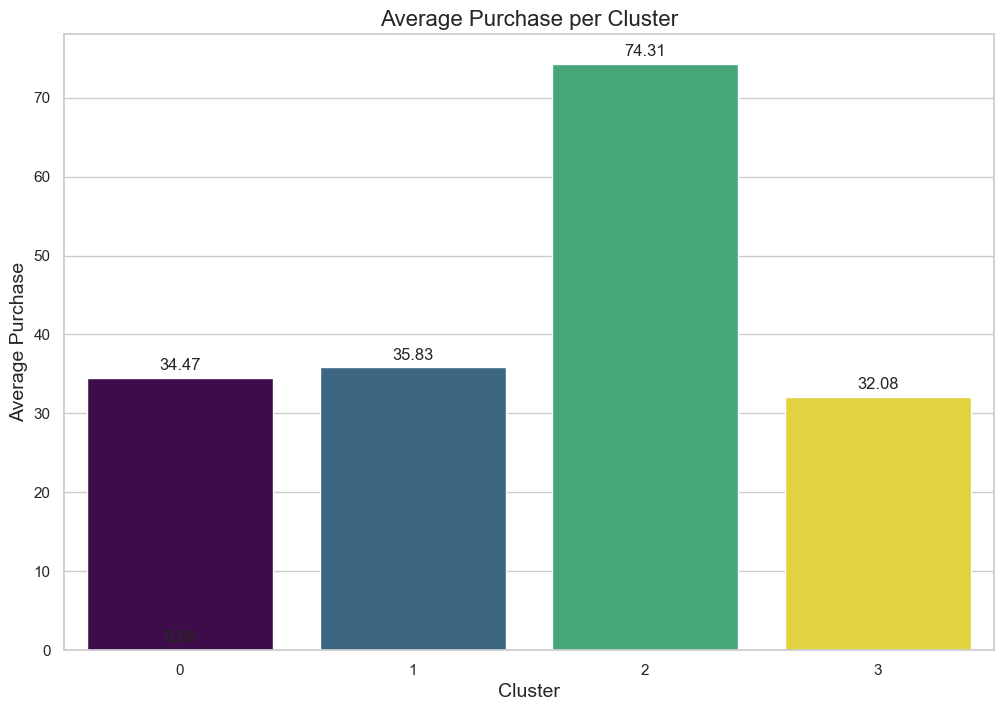

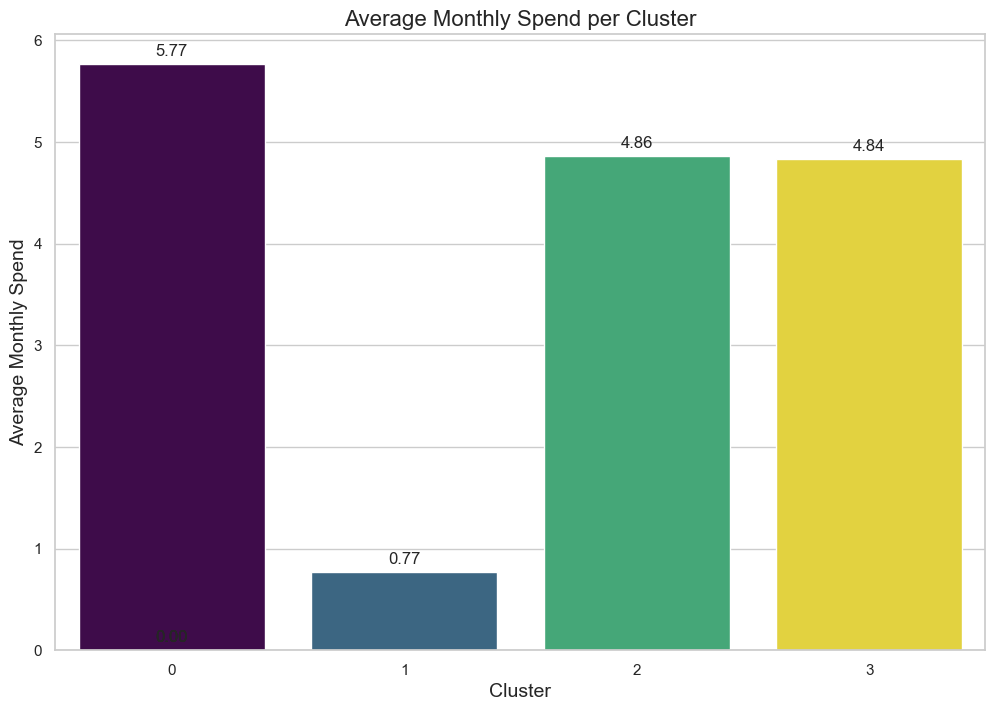

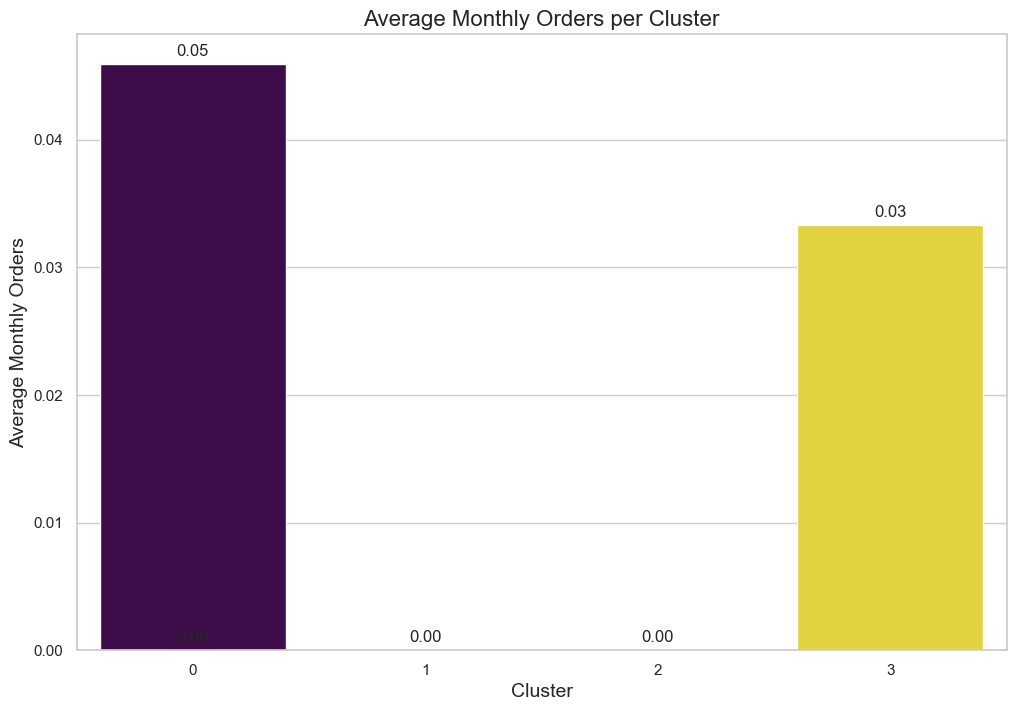

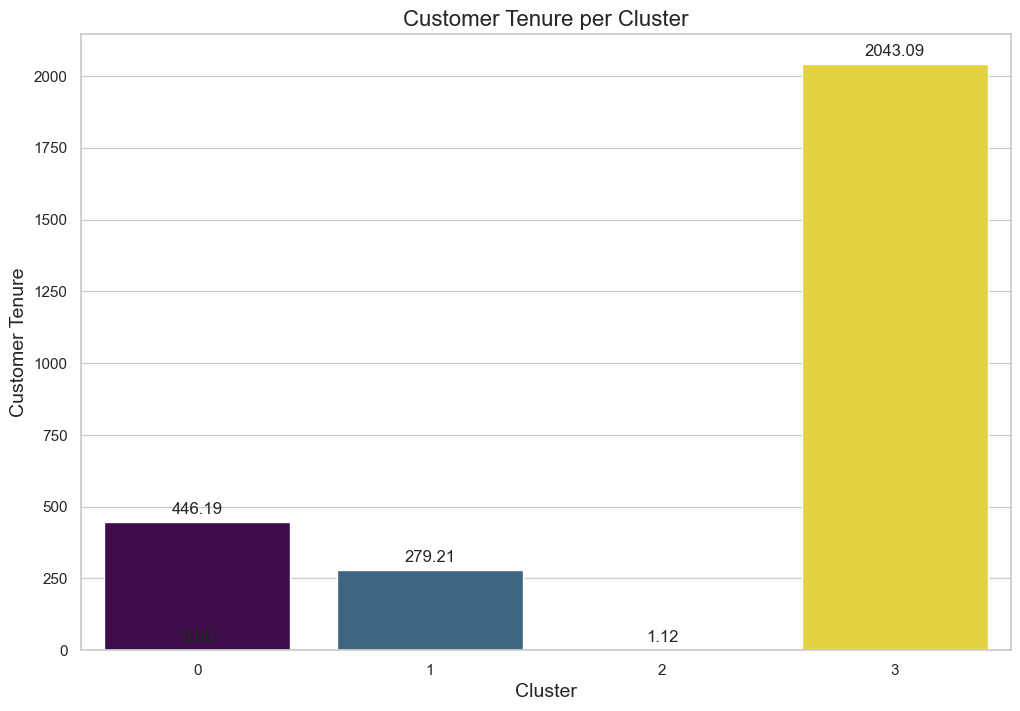

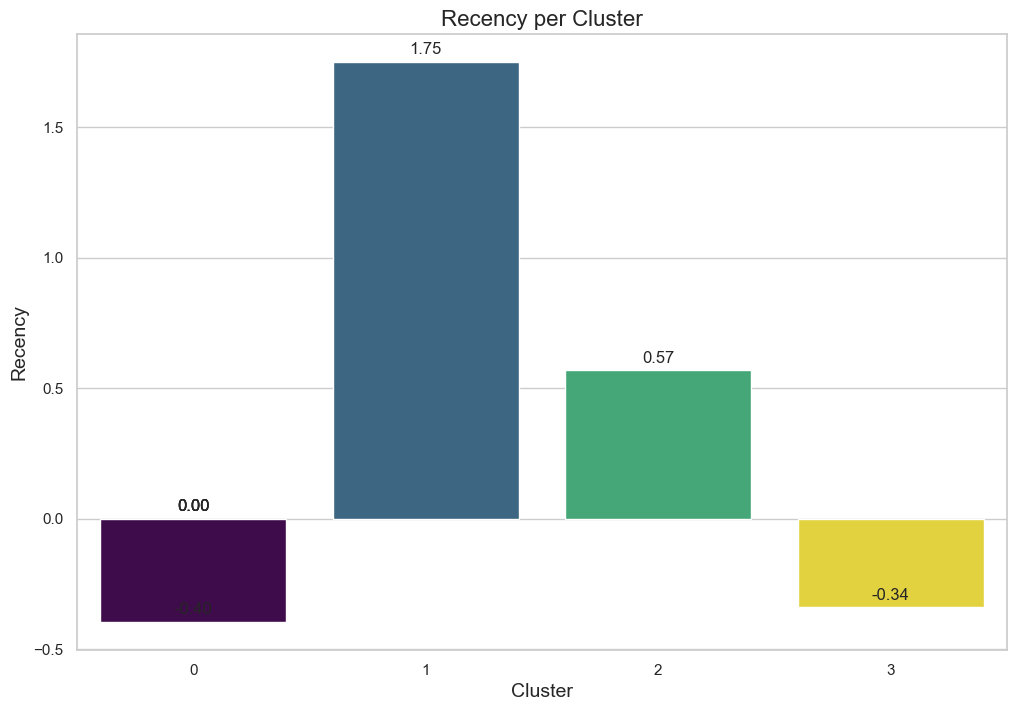

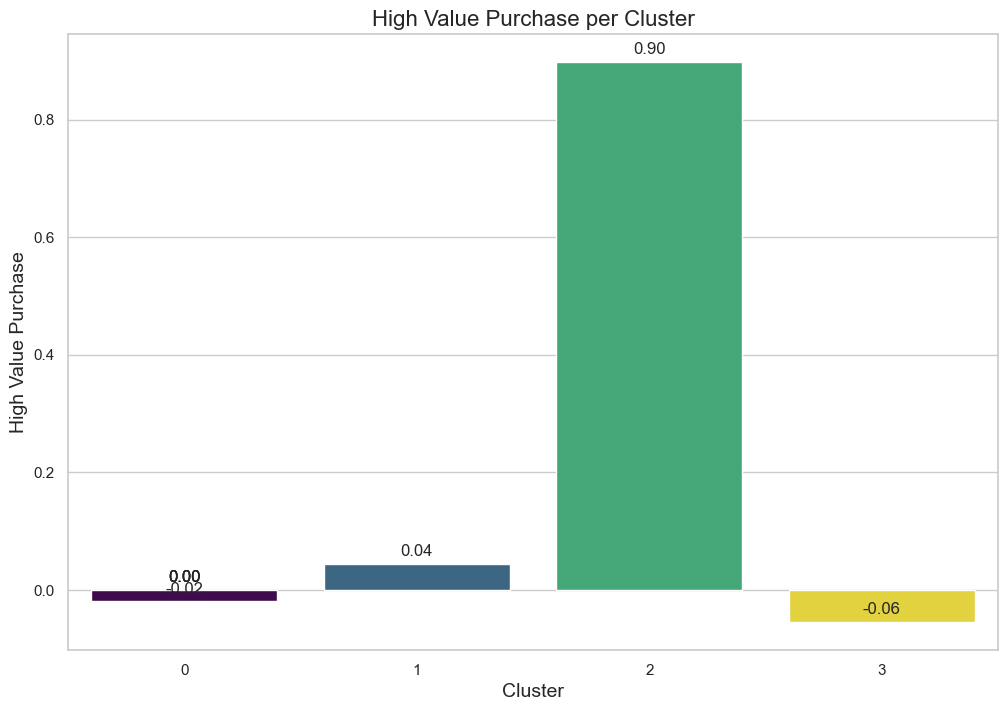

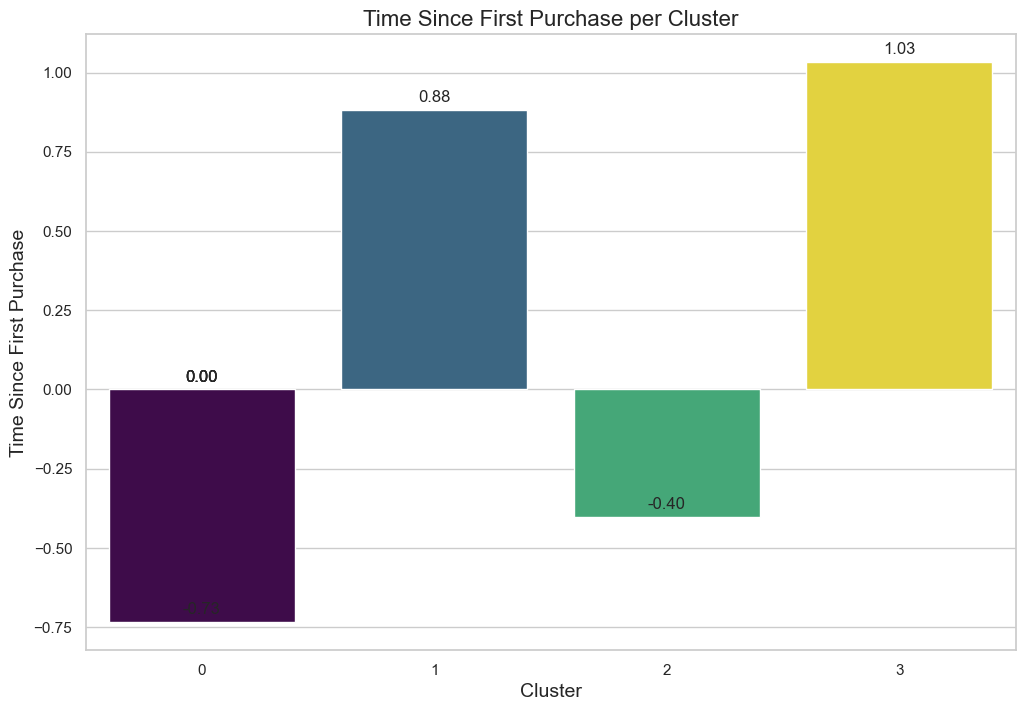

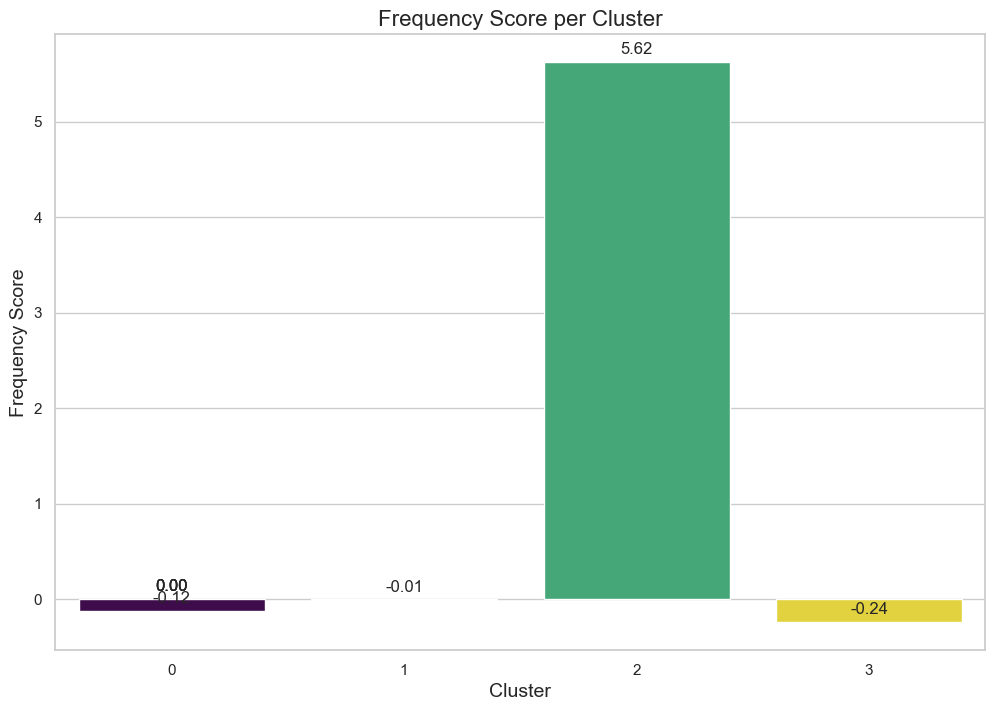

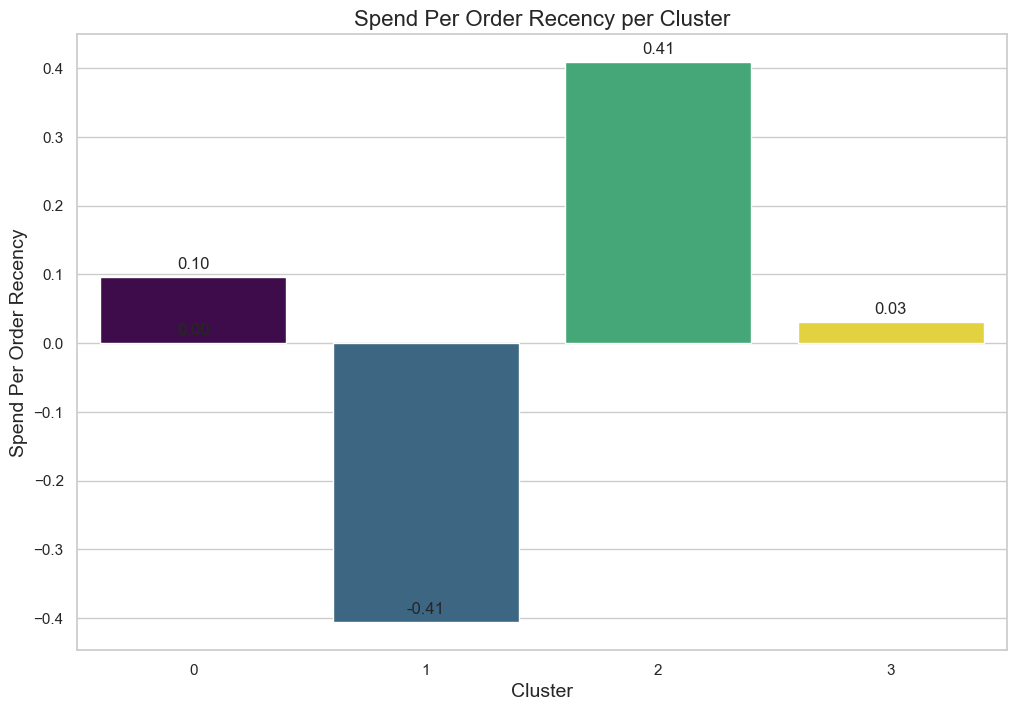

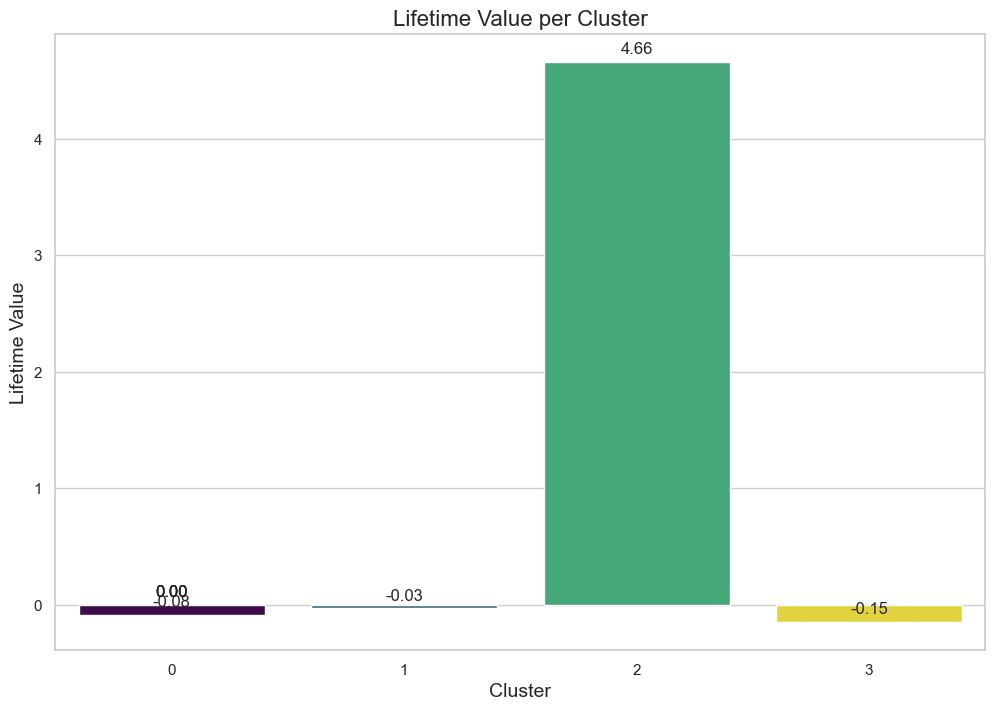

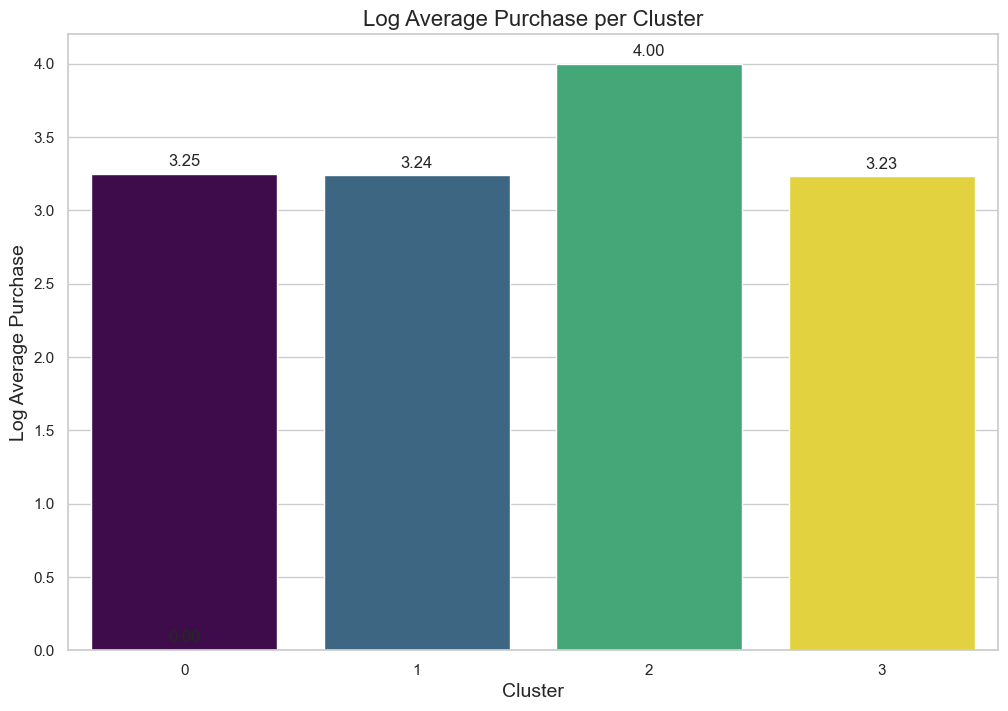

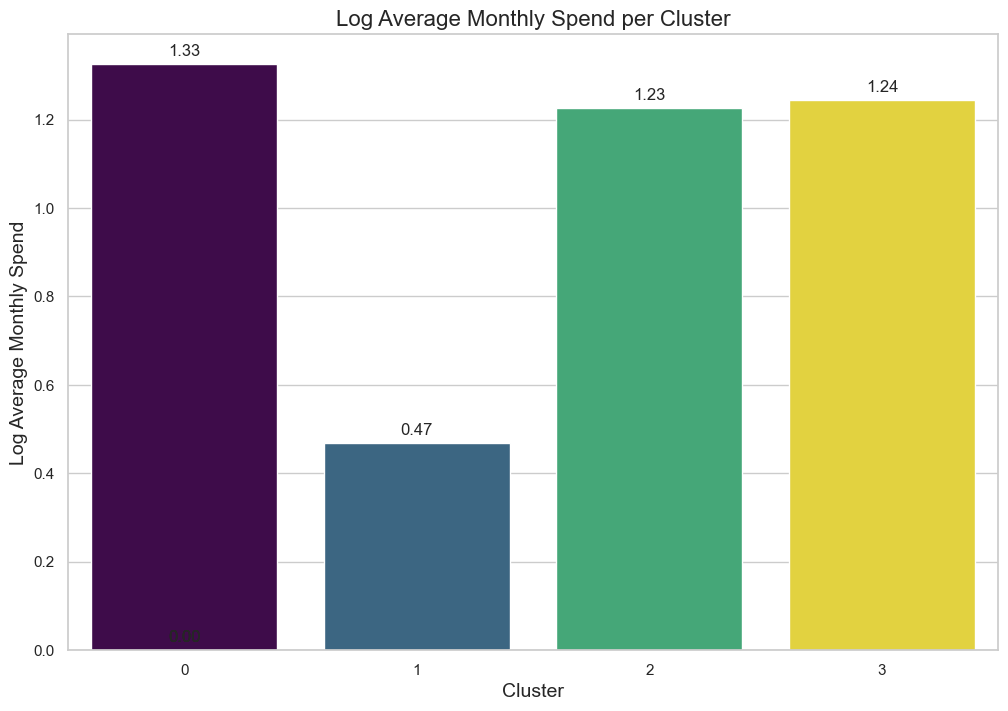

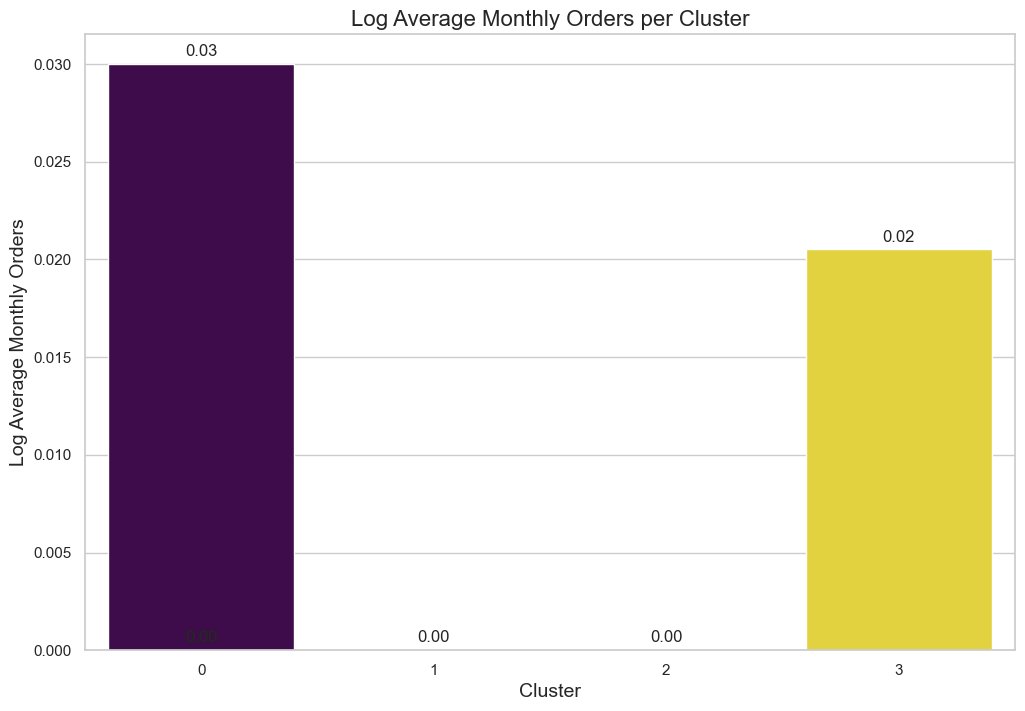

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of characteristics to visualize
characteristics = ['total_spent', 'total_orders', 'average_purchase', 'average_monthly_spend', 
                   'average_monthly_orders', 'customer_tenure', 'recency', 'high_value_purchase', 
                   'time_since_first_purchase', 'frequency_score', 'spend_per_order_recency', 
                   'lifetime_value', 'log_average_purchase', 'log_average_monthly_spend', 
                   'log_average_monthly_orders']

# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", as_cmap=True)

# Plot each characteristic separately
for characteristic in characteristics:
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='cluster_label', y=characteristic, data=df_copy, estimator=np.mean, errorbar=None, palette=palette, hue='cluster_label', dodge=False)
    
    # Add title and labels
    plt.title(f'{characteristic.replace("_", " ").title()} per Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel(f'{characteristic.replace("_", " ").title()}', fontsize=14)
    
    # Add data labels
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=12)
    
    # Adjust the legend
    ax.legend_.remove()
    
    plt.show()